In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats    
import math
from sklearn.decomposition import PCA
from scipy.interpolate import Rbf

In [2]:
daily_cases = pd.read_csv("./daily-cases-covid-19-who.csv")
daily_deaths = pd.read_csv("./daily-deaths-covid-19-who.csv")
total_cases = pd.read_csv("./total-cases-covid-19-who.csv")
total_deaths = pd.read_csv("./total-deaths-covid-19-who.csv")
full_data = pd.read_csv("./full_data.csv").dropna()
tested_people = pd.read_csv("./covid19-tests-per-million-people.csv")

In [39]:
bed_people = pd.read_csv("./API_SH.MED.BEDS.ZS_DS2_en_csv_v2_821439.csv", header = 2, na_values="")
dropped = [bed_people.columns[i] for i in range(4, 24)]
bed_people_fra = bed_people.drop(dropped, axis=1).drop(["2014", "2015", "2016", "2017", "2018", "2019", 'Unnamed: 64', "2008"], axis=1).dropna()
bed_people_amer=bed_people[bed_people[(bed_people["Country Name"] == "United States")].dropna(axis=1).columns].dropna()
bed_people_jp=bed_people[bed_people[(bed_people["Country Name"] == "Japan")].dropna(axis=1).columns].dropna()
#(bed_people_fra.columns & bed_people_amer.columns & bed_people_jp.columns)
bed_people_2013=pd.DataFrame(bed_people.set_index("Country Name").loc[bed_people.set_index("Country Name")["2013"].dropna().index, :]["2013"])
bed_people_2013.columns = ["2013_beds_per_thd"]
bed_people_2013.head(10)

,2013_beds_per_thd
Country Name,
Afghanistan,0.500000
Albania,2.900000
Arab World,1.151899
United Arab Emirates,1.200000
Argentina,4.900000
Armenia,4.100000
Antigua and Barbuda,3.900000
Austria,7.600000
Azerbaijan,4.700000


In [40]:
bed_people_ts=bed_people[(bed_people_fra.columns & bed_people_amer.columns & bed_people_jp.columns)].dropna()
bed_people_ts.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1980,1985,1993,1994,1995,1996,...,1998,1999,2000,2001,2002,2003,2005,2006,2009,2012
3,Albania,ALB,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,4.271700,4.138800,3.831400,3.017100,3.190000,3.140000,...,3.050000,3.030000,3.300000,3.300000,3.100000,3.100000,3.100000,3.100000,2.800000,2.9000
8,Armenia,ARM,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,8.395400,8.699200,8.214700,7.766000,7.640000,7.130000,...,6.660000,6.200000,6.400000,5.000000,4.300000,4.400000,4.500000,4.400000,3.700000,4.0000
12,Austria,AUT,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,11.200000,10.900000,9.400000,9.500000,9.400000,9.300000,...,9.000000,8.900000,7.900000,7.800000,7.800000,7.700000,7.700000,7.700000,7.700000,7.7000
13,Azerbaijan,AZE,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,9.745200,9.896800,10.487500,10.070600,10.020000,9.810000,...,9.060000,8.900000,8.700000,8.500000,8.400000,8.300000,8.200000,7.900000,7.500000,4.6000
19,Bulgaria,BGR,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,8.850600,9.114000,10.494200,10.196100,10.370000,10.470000,...,8.410000,7.490000,7.400000,7.200000,6.500000,6.300000,6.400000,6.200000,6.600000,6.6000
23,Belarus,BLR,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,12.546100,13.071300,12.476200,12.463900,12.380000,12.270000,...,12.420000,12.640000,12.600000,12.600000,11.900000,11.300000,11.100000,11.200000,11.100000,11.3000
38,China,CHN,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,2.230000,2.370000,2.630000,2.630000,2.610000,2.550000,...,2.530000,2.520000,2.520000,2.520000,2.450000,2.200000,2.450000,2.230000,4.200000,4.2000
53,Germany,DEU,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,11.500000,11.000000,9.700000,9.700000,9.700000,9.600000,...,9.300000,9.200000,9.100000,9.000000,8.900000,8.700000,8.500000,8.300000,8.200000,8.2000
59,East Asia & Pacific (excluding high income),EAP,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,2.223728,2.122005,2.291977,2.349609,2.572055,2.540837,...,2.255705,2.504883,2.443497,2.403245,2.175777,2.200209,2.426512,2.105850,3.875916,3.6474
61,East Asia & Pacific,EAS,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,3.324576,3.286507,3.435136,3.527017,3.801246,3.803587,...,3.393182,3.700678,3.611604,3.370823,3.084765,3.413657,3.358222,3.171012,4.778242,4.4436


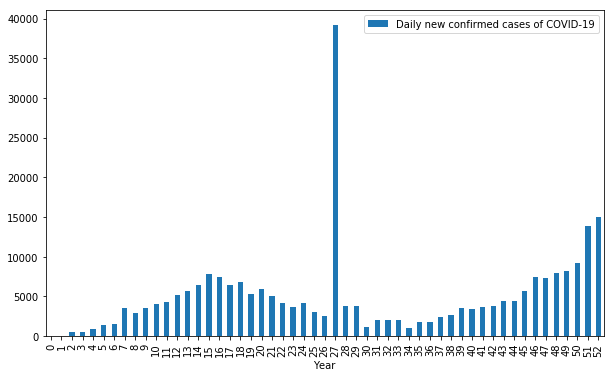

In [41]:
daily_cases.groupby("Year").sum().plot.bar(figsize=(10, 6))

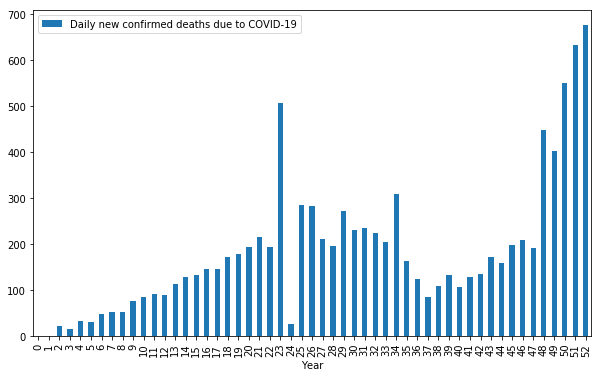

In [42]:
daily_deaths.groupby("Year").sum().plot.bar(figsize=(10, 6))

Text(0,0.5,'Number of people reported')

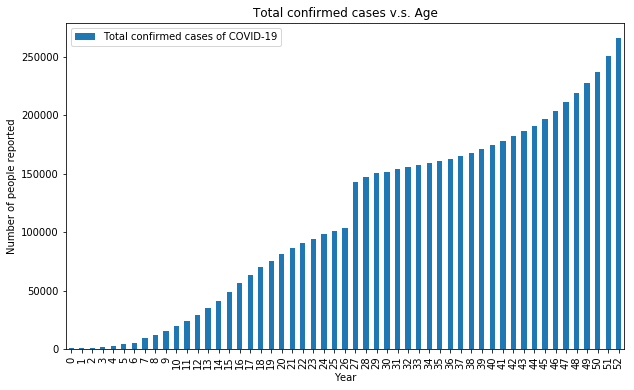

In [43]:
total_cases.groupby("Year").sum().plot.bar(figsize=(10, 6), title="Total confirmed cases v.s. Age")
plt.ylabel("Number of people reported")

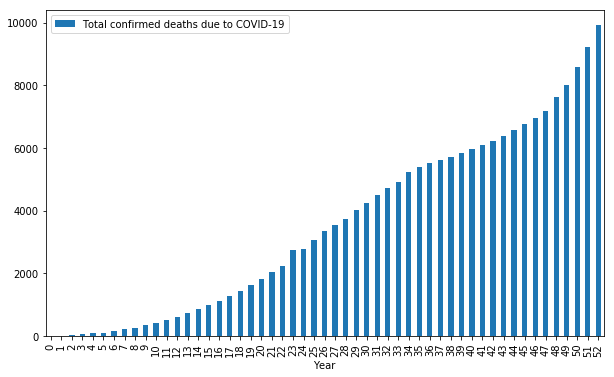

In [44]:
total_deaths.groupby("Year").sum().plot.bar(figsize=(10, 6))

Text(0,0.5,'Number of people reported')

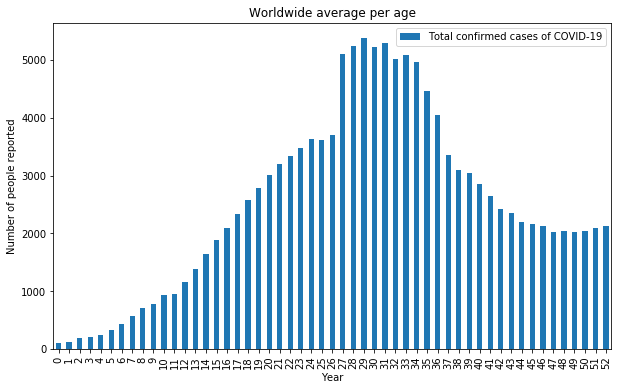

In [45]:
total_cases.groupby("Year").mean().plot.bar(figsize=(10, 6), title="Worldwide average per age")
plt.ylabel("Number of people reported")

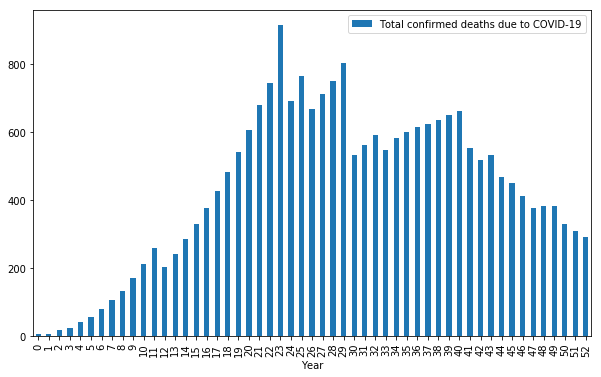

In [46]:
total_deaths.groupby("Year").mean().plot.bar(figsize=(10, 6))

In [47]:
full_data[full_data["date"]=="2020-03-13"][["location","total_cases", "total_deaths"]]

,location,total_cases,total_deaths
39,Algeria,25,1.0
60,Argentina,31,1.0
121,Australia,140,3.0
273,Bulgaria,7,1.0
377,Canada,138,1.0
440,China,80991,3180.0
561,Egypt,67,1.0
676,France,2860,61.0
746,Germany,2369,6.0
771,Greece,98,1.0


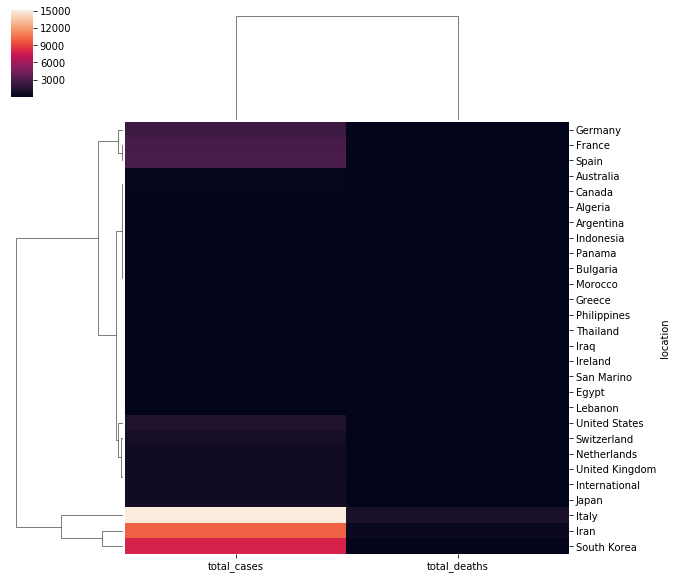

In [48]:

sns.clustermap(full_data[full_data["date"]=="2020-03-13"][["location","total_cases", "total_deaths"]].set_index("location").drop(["China","Worldwide"], axis=0))

Text(0,0.5,'Number of people reported')

<Figure size 720x432 with 0 Axes>

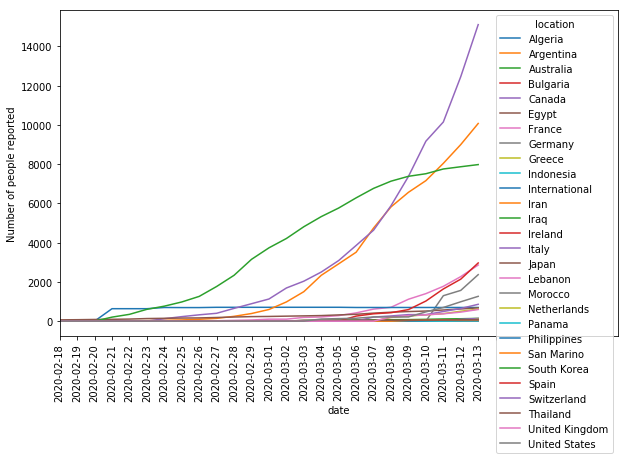

In [49]:
plt.figure(figsize=(10, 6))

tmp=full_data.pivot_table(values=["total_cases","total_deaths"], index="location", columns='date').fillna(0)["total_cases"].drop(["China", "Worldwide"]).T
ticks = [tmp.index[i] for i in range(len(tmp.index))]
ax=tmp.plot.line(figsize=(10, 6), xticks=np.linspace(0, len(tmp.index), len(tmp.index)+1))
fig=ax.set_xticklabels(tmp.index, rotation=90)
#plt.legend(loc="upper right")
plt.xlim(28, 60)
plt.ylabel("Number of people reported")
#plt.legend(loc="upper left")

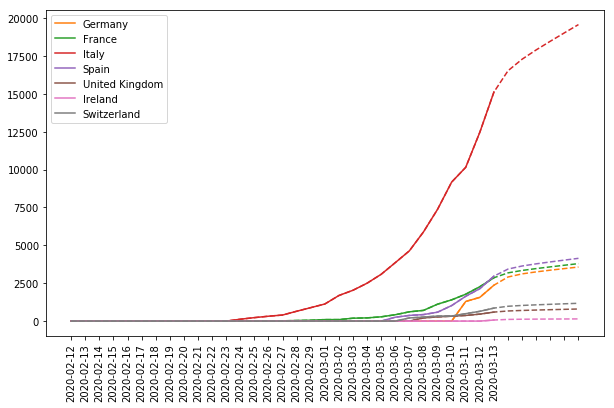

In [50]:
retain=[tmp.index[i] for i in range(22, len(tmp.index))]
countries = ["Germany", "France", "Italy", "Spain", "United Kingdom", "Ireland", "Switzerland"]

plt.figure(figsize=(10, 6))
fig=plt.subplot(111)
xnew = np.linspace(0, len(retain)+5, len(retain)+6)
fig.set_xticks(xnew)
fig.set_xticklabels(tmp.index[22:len(tmp.index)], rotation=90)
for i in range(len(countries)):
    tck = Rbf(np.linspace(0, len(retain)-1, len(retain)), tmp[countries[i]].loc[retain])
    ynew = tck(xnew)
    
    
        
    plt.plot(xnew, ynew, color="C"+str(i+1), ls="--")

    plt.plot(np.linspace(0, len(retain)-1, len(retain)), tmp[countries[i]].loc[retain], color="C"+str(i+1), ls="-")
    
plt.legend(loc="upper left")

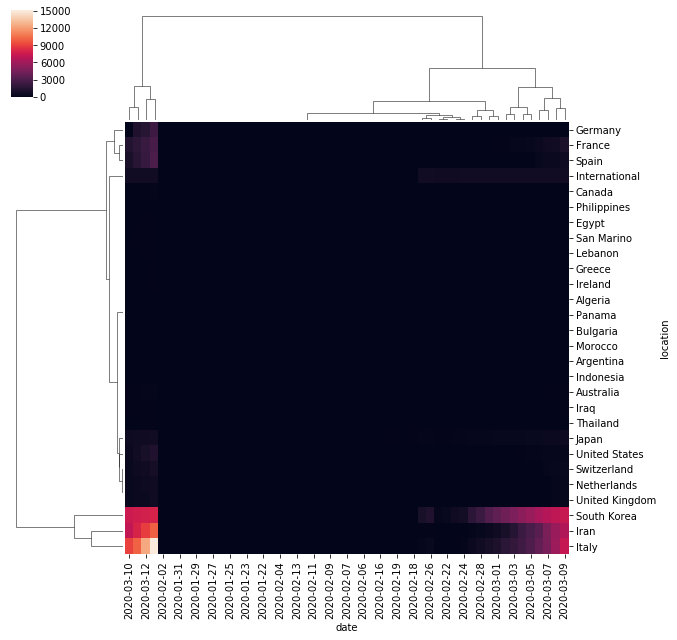

In [51]:
sns.clustermap(tmp.T)

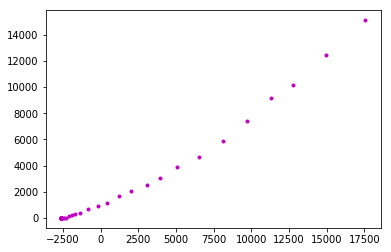

In [52]:
pca = PCA(n_components=2)
vecs1=pca.fit_transform(tmp)
plt.Figure(figsize=(8, 8))
plt.plot(vecs1[:,0], tmp["Italy"], 'm.')

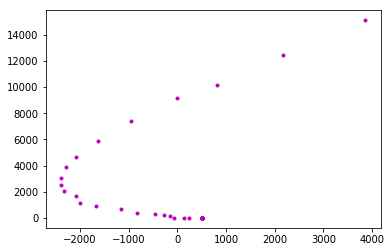

In [63]:
plt.Figure(figsize=(8, 8))
mask=(np.log2((tmp["Italy"] - tmp.shift(periods=1)["Italy"])/tmp.shift(periods=1)["Italy"]) < 0)
plt.plot(vecs1[:,1], tmp["Italy"] , 'm.')

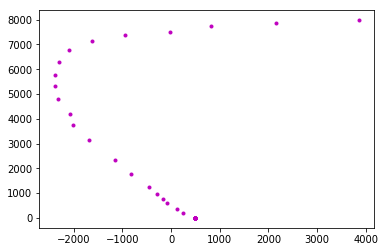

In [54]:
plt.Figure(figsize=(8, 8))
plt.plot(vecs1[:,1], tmp["South Korea"], 'm.')

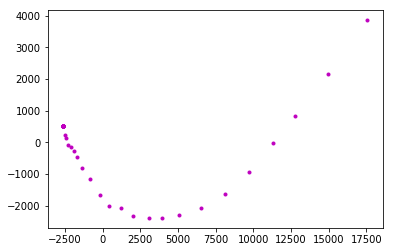

In [55]:
plt.Figure(figsize=(8, 8))
plt.plot(vecs1[:,0], vecs1[:,1], 'm.')

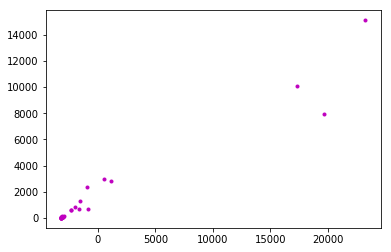

In [56]:
pca = PCA(n_components=2)
vecs2=pca.fit_transform(tmp.T)
plt.Figure(figsize=(8, 8))
plt.plot(vecs2[:,0], tmp.T["2020-03-13"], 'm.')

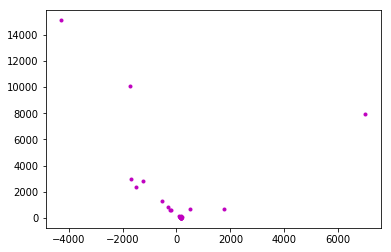

In [57]:
plt.Figure(figsize=(8, 8))
plt.plot(vecs2[:,1], tmp.T["2020-03-13"], 'm.')

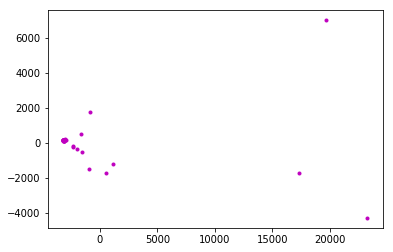

In [58]:
plt.Figure(figsize=(8, 8))
plt.plot(vecs2[:,0],vecs2[:,1], 'm.')